In [1]:
from astropy.io import fits
import numpy as np
from matplotlib import pyplot as plt
from glob import glob
import seaborn as sns
from scipy import stats
import matplotlib.mlab as mlab
from scipy.optimize import curve_fit
import os
from astropy.wcs import WCS
from photutils import DAOStarFinder
from astropy.stats import mad_std
from photutils import aperture_photometry, CircularAperture, CircularAnnulus
from area import area
%matplotlib inline
sns.set()

In [2]:
NNser_bias_files = os.listdir('C:/Users/seanj/3rd year labs/astro analysis/data_2019/NNser/bias/')
x = len(NNser_bias_files)

NNser_bias_directories = []
for i in range(x):
    NNser_bias_directories.append(f'C:/Users/seanj/3rd year labs/astro analysis/data_2019/NNser/bias/{NNser_bias_files[i]}')

bias_data = np.zeros(shape=(2048, 2098))
for file in NNser_bias_directories:
    image = fits.open(file)
    bias_data += (image[0].data)

NNser_master_bias = bias_data/len(NNser_bias_directories)

In [3]:
NNser_flat_files = os.listdir('C:/Users/seanj/3rd year labs/astro analysis/data_2019/NNser/flats/clear/')
x = len(NNser_flat_files)

NNser_flat_directories = []
for i in range(x):
    NNser_flat_directories.append(f'C:/Users/seanj/3rd year labs/astro analysis/data_2019/NNser/flats/clear/{NNser_flat_files[i]}')

flat_data = np.zeros(shape=(2048, 2098))
for file in NNser_flat_directories:
    image = fits.open(file)
    flat_data += ((image[0].data) - NNser_master_bias)

NNser_master_flats = flat_data/len(NNser_flat_directories)
NNser_master_flats_normalised = NNser_master_flats/np.mean(NNser_master_flats)

In [4]:
# in this cell we are comparing the difference between reduced and non-reduced images
NNser_object_clear = os.listdir('C:/Users/seanj/3rd year labs/astro analysis/data_2019/NNser/object/clear/')
x = len(NNser_object_clear)

NNser_object_clear_directories = []
for i in range(x):
    NNser_object_clear_directories.append(f'C:/Users/seanj/3rd year labs/astro analysis/data_2019/NNser/object/clear/{NNser_object_clear[i]}')


image = fits.open(NNser_object_clear_directories[1])
image1 = (image[0].data-NNser_master_bias)/NNser_master_flats_normalised
image1 = image1[:,50:]

#print(image[0].header)

C:\Users\seanj\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
C:\Users\seanj\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


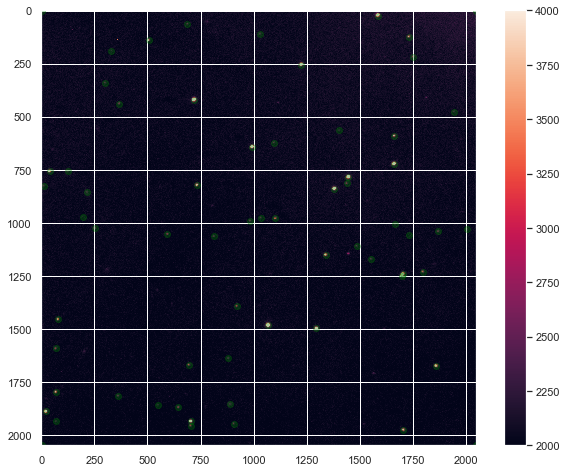

  aperture_sum_0  
------------------
 136913.9730015701
148848.54406557832
 935734.7420730945
 266078.0433708573
 264363.0750450239
 355956.1813817688
386147.43973540893
248734.95120297678
 290734.2479609883
  839038.349103323
               ...
269291.30130460917
251003.49860087587
 295569.1753710139
 584111.3403769035
 633811.1201254303
253051.82613081625
 269328.4398234589
297133.63046970405
404799.58977964846
133521.49731223792
 133729.2561092013
Length = 65 rows


In [14]:
sigma = mad_std(image1)

daofind = DAOStarFinder(fwhm=6, threshold=5*sigma)
sources = daofind(image1)

aperture_area = np.pi*6**2
annulus_aperture_area = np.pi*15**2 - np.pi*100**2

# Get the positions of sources in the field from the table above.
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
# Set up aperture and annulus
aperture = CircularAperture(positions, r=6.)
annulus_aperture = CircularAnnulus(positions, r_in=10., r_out=15.)
# Make a list of apertures
apers = [aperture, annulus_aperture]
# And run aperture photometry
phot_table = aperture_photometry(image1, apers)
# We calculate the mean counts in each pixel in the background annulus, and then multiply by the area
# in the aperture to get the total background counts within each aperture
bkg_mean = phot_table['aperture_sum_1'] / annulus_aperture_area
bkg_sum = bkg_mean * aperture_area
# Now we get the final table of background subtracted counts within each aperture
final_sum = phot_table['aperture_sum_0'] - bkg_sum

fig= plt.figure(figsize=(10,8))
plt.scatter(sources['xcentroid'], sources['ycentroid'], alpha=0.3, color="green")
plt.imshow(image1, vmin=2000, vmax=4000)
plt.colorbar()
plt.show()

# We can covert to magnitudes with
magnitudes = -2.5*np.log10(final_sum)

print(final_sum)

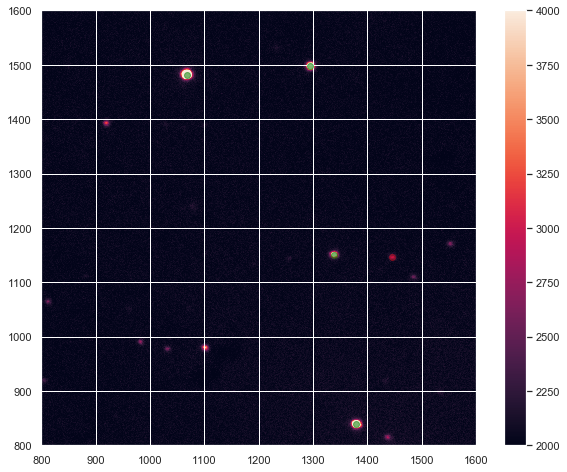

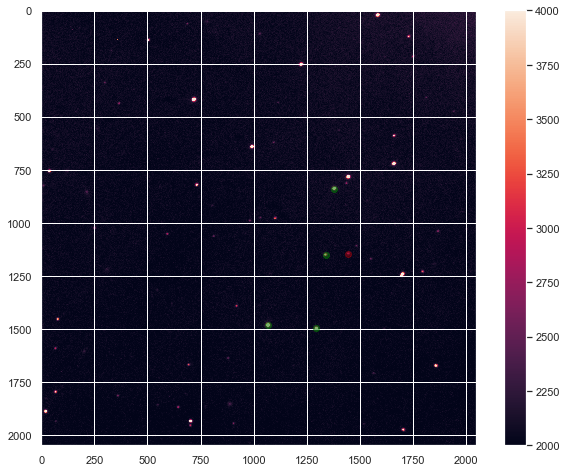

In [19]:
# here i was just using the DAOStarFinder inorder to accurately determine the location of the refrence stars
xcentroids_cal = [1338.4475620048397,1294.8859844473714,1067.579209977523,1379.4417361202306]
ycentroids_cal = [1150.7320661531699,1497.2093184654789,1481.902428352763,839.0148119303864]

xcentroid_NN = 1446
ycentroid_NN = 1147

fig= plt.figure(figsize=(10,8))
plt.imshow(image1, vmin=2000, vmax=4000)
plt.colorbar()
plt.xlim(800,1600)
plt.ylim(800,1600)
plt.scatter(xcentroids_cal,ycentroids_cal, alpha=0.5, color="green")
plt.scatter(xcentroid_NN,ycentroid_NN, alpha=0.3, color="red")
plt.show()

fig= plt.figure(figsize=(10,8))
plt.imshow(image1, vmin=2000, vmax=4000)
plt.colorbar()
plt.scatter(xcentroids_cal,ycentroids_cal, alpha=0.5, color="green")
plt.scatter(xcentroid_NN,ycentroid_NN, alpha=0.3, color="red")
plt.show()

In [21]:
#defining the refrence star magnitudes
refrence_mag = [15.8,15.1,13.7,13,7]

# Get the positions of sources in the field from the table above.
positions = np.transpose((xcentroids_cal,ycentroids_cal))

# Set up aperture and annulus
aperture = CircularAperture(positions, r=6.)
annulus_aperture = CircularAnnulus(positions, r_in=10., r_out=15.)

# Make a list of apertures
apers = [aperture, annulus_aperture]

#define the areas of the apertures
aperture_area = np.pi*6**2
annulus_aperture_area = np.pi*15**2 - np.pi*10**2

ZP_list = []

for image in NNser_object_clear_directories:
    image = fits.open(image)
    image1 = (image[0].data-NNser_master_bias)/NNser_master_flats_normalised
    phot_table = aperture_photometry(image1, apers)

    # We calculate the mean counts in each pixel in the background annulus, and then multiply by the area
    # in the aperture to get the total background counts within each aperture
    bkg_mean = phot_table['aperture_sum_1']/annulus_aperture_area 
    bkg_sum = bkg_mean * aperture_area

    # Now we get the final table of background subtracted counts within each aperture
    final_sum = phot_table['aperture_sum_0'] - bkg_sum
    print(final_sum)
    
    ZP = 2.5*np.log10(final_sum) # refrence_mag
    ZP_list.append(ZP)
    

C:\Users\seanj\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\seanj\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
C:\Users\seanj\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in log10


  aperture_sum_0  
------------------
-1140.856034187309
277.22444474487565
-535.1216288509022
-4.804329295846401
   aperture_sum_0  
-------------------
  123.1097573984589
 -719.3357704574591
-256.49879942424013
  66.32366874135914
   aperture_sum_0  
-------------------
-378.26182705015526
  -518.428201707371
 -232.2501268031483
  704.8880005469255
  aperture_sum_0  
------------------
-557.0327384466073
-85.61102504617884
161.82720889314078
 556.7527263636002
   aperture_sum_0  
-------------------
-143.28036448865896
 -1470.703007991484
  686.5331805755268
  328.8006853967672
   aperture_sum_0  
-------------------
 159.88264631357742
 425.85423769574845
-1012.5118225411861
  622.0939775611041
  aperture_sum_0  
------------------
 225.7981447596103
 792.5430356342695
-245.2717791083851
477.53273410745896
   aperture_sum_0  
-------------------
 -625.8232246451662
-368.82697450421983
 416.68666873598704
 1263.8641928675352
   aperture_sum_0  
-------------------
 -504.152525090146

In [ ]:
M91_bias_files = os.listdir('C:/Users/seanj/3rd year labs/astro analysis/data_2019/M91/bias/')
x = len(M91_bias_files)

M91_bias_directories = []
for i in range(x):
    M91_bias_directories.append(f'C:/Users/seanj/3rd year labs/astro analysis/data_2019/M91/bias/{M91_bias_files[i]}')

bias_data = np.zeros(shape=(2048, 2098))
for file in M91_bias_directories:
    image = fits.open(file)
    bias_data += (image[0].data)

M91_master_bias = bias_data/len(M91_bias_directories)

In [ ]:
M91_flat_files = os.listdir('C:/Users/seanj/3rd year labs/astro analysis/data_2019/M91/flats/B/')
x = len(M91_flat_files)

M91_flat_directories = []
for i in range(x):
    M91_flat_directories.append(f'C:/Users/seanj/3rd year labs/astro analysis/data_2019/M91/flats/B/{M91_flat_files[i]}')

flat_data = np.zeros(shape=(2048, 2098))
for file in M91_flat_directories:
    image = fits.open(file)
    flat_data += ((image[0].data) - M91_master_bias)

M91_master_flats_B = flat_data/len(M91_flat_directories)
M91_master_flats_B_normalised = M91_master_flats_B/np.mean(M91_master_flats_B)

In [ ]:
M91_flat_files = os.listdir('C:/Users/seanj/3rd year labs/astro analysis/data_2019/M91/flats/Halpha_NII/')
x = len(M91_flat_files)

M91_flat_directories = []
for i in range(x):
    M91_flat_directories.append(f'C:/Users/seanj/3rd year labs/astro analysis/data_2019/M91/flats/Halpha_NII/{M91_flat_files[i]}')

flat_data = np.zeros(shape=(2048, 2098))
for file in M91_flat_directories:
    image = fits.open(file)
    flat_data += ((image[0].data) - M91_master_bias)

M91_master_flats_Halpha_NII = flat_data/len(M91_flat_directories)
M91_master_flats_Halpha_NII_normalised = M91_master_flats_Halpha_NII/np.mean(M91_master_flats_Halpha_NII)

In [ ]:
M91_flat_files = os.listdir('C:/Users/seanj/3rd year labs/astro analysis/data_2019/M91/flats/V/')
x = len(M91_flat_files)

M91_flat_directories = []
for i in range(x):
    M91_flat_directories.append(f'C:/Users/seanj/3rd year labs/astro analysis/data_2019/M91/flats/V/{M91_flat_files[i]}')

flat_data = np.zeros(shape=(2048, 2098))
for file in M91_flat_directories:
    image = fits.open(file)
    flat_data += ((image[0].data) - M91_master_bias)

M91_master_flats_V = flat_data/len(M91_flat_directories)
M91_master_flats_V_normalised = M91_master_flats_V/np.mean(M91_master_flats_V)

In [ ]:
M91_object_B = os.listdir('C:/Users/seanj/3rd year labs/astro analysis/data_2019/M91/object/B/')
x = len(M91_object_B)

M91_object_B_directories = []
for i in range(x):
    M91_object_B_directories.append(f'C:/Users/seanj/3rd year labs/astro analysis/data_2019/M91/object/B/{M91_object_B[i]}')

    
B_filter_data = np.zeros(shape=(2048, 2098))
for file in M91_object_B_directories[1:]:
    image = fits.open(file)
    B_filter_data += ((image[0].data) - M91_master_bias)/M91_master_flats_B_normalised
    
#wcs = WCS(image[0].header)
#plt.subplot(projection=wcs)

plt.imshow(B_filter_data,vmin=0, vmax=1000)
plt.xlim(1000,1200)
plt.ylim(800,1000)
plt.colorbar()
plt.show()

In [ ]:
M91_object_Halpha_NII = os.listdir('C:/Users/seanj/3rd year labs/astro analysis/data_2019/M91/object/Halpha_NII/')
x = len(M91_object_Halpha_NII)

M91_object_Halpha_NII_directories = []
for i in range(x):
    M91_object_Halpha_NII_directories.append(f'C:/Users/seanj/3rd year labs/astro analysis/data_2019/M91/object/Halpha_NII/{M91_object_Halpha_NII[i]}')

Halpha_NII_filter_data = np.zeros(shape=(2048, 2098))
for file in M91_object_Halpha_NII_directories:
    image = fits.open(file)
    Halpha_NII_filter_data += ((image[0].data) - M91_master_bias)/M91_master_flats_Halpha_NII_normalised

Halpha_NII_filter_data = Halpha_NII_filter_data
    
#wcs = WCS(image[0].header)
#plt.subplot(projection=wcs)

plt.imshow(Halpha_NII_filter_data,vmin=0, vmax=700)
plt.xlim(1000,1200)
plt.ylim(800,1000)
plt.colorbar()
plt.show()


In [1]:
M91_object_V = os.listdir('C:/Users/seanj/3rd year labs/astro analysis/data_2019/M91/object/V/')
x = len(M91_object_V)

M91_object_V_directories = []
for i in range(x):
    M91_object_V_directories.append(f'C:/Users/seanj/3rd year labs/astro analysis/data_2019/M91/object/V/{M91_object_V[i]}')

V_filter_data = np.zeros(shape=(2048, 2098))
for file in M91_object_V_directories:
    image = fits.open(file)
    V_filter_data += ((image[0].data) - M91_master_bias)/M91_master_flats_V_normalised 
    
V_filter_data = V_filter_data
    
#wcs = WCS(image[0].header)
#plt.subplot(projection=wcs)

plt.imshow(V_filter_data,vmin=0, vmax=2500)
plt.xlim(1000,1200)
plt.ylim(800,1000)
plt.colorbar()
plt.show()

NameError: name 'os' is not defined

In [ ]:
for i in range(800,900):  
    for j in range(1000,1100):
        if np.abs(V_filter_data[i][j]) >  2000:
           
            
no_outlier = 0

for i in range(1039):  
    for j in range(1391):
        if avg_master_bias1[i][j] == 0:
            no_outlier += 1
            avg_master_bias1[i][j] = mu
            
print(no_outlier)